In [34]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [35]:
def containsMarket(column, market=""):
    if market:
        return market in column
    return "am" in column or "sm" in column

In [36]:
# read all storage folders to extract training info, i.e. markets and save it to envs
try:
    training_folders = os.listdir('storage') 
except(FileNotFoundError):
    training_folders = []
envs = {}

# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

for folder in training_folders:
    envs[folder] = {}
    # agents = folder.split("-")[0]
    if containsMarket(folder, "am"):
        market = "am" + folder.split("-am")[1]
        envs[folder]["market"] = market  
    elif containsMarket(folder, "sm"):
        market = "sm" + folder.split("-sm")[1]
        envs[folder]["market"] = market
    else:
        if folder == "3-ppo" or folder == "1-ppo":
            envs[folder]["compare_with"] = [f for f in training_folders if folder in f]

    # read csv file (if it exists)
    try:
        df_settings_dict[folder] = pd.read_csv('storage/'+folder+'/log.csv')
        # add setting to the df columns
        df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns]
    except:
        continue

# join all dataframes (one per setting)
df = pd.concat([df for df in df_settings_dict.values()], axis=1)
# print(df.columns)
# print(envs)

In [134]:
keys = ["mean_reward", "mean_trades", "mean_grid_coloration_percentage", "mean_num_reset_fields"]

frames_col = ""
plotting_cols = []
for col in df.columns:
    if not "1-ppo" in col:
        continue

    if "frames" in col and not frames_col:
        # since frames don't differ between settings, but i.e. three agents probably 
        # needs more frames pick the column that has the most values
        # (for example check if the value of the last index is not NaN)
        last_value = df[col].iloc[-1]
        if not np.isnan(last_value):
            frames_col = col
            plotting_cols.append(col)

    if not "reward" in col: # in this case its agent specific
        if any(key in col for key in keys) and col not in plotting_cols:
            plotting_cols.append(col)
    elif any(key in col for key in keys):
        if "agent_0" in col:
            # always safe agent 0 values
            plotting_cols.append(col)
        elif "mixed" in col or "sm" in col or "am" in col:
            # always add mixed or market values for each agent since they differ from each other
            plotting_cols.append(col) 
# print(plotting_cols)

# first create wideform
df_wideform = df[plotting_cols].copy()
# reshape dataframe into longform
df_rewards = df_wideform.melt(id_vars=[frames_col], var_name="agents", 
value_vars=[col for col in plotting_cols if "reward" in col], value_name="mean_reward")
df_rewards.rename(columns={frames_col:'frames'}, inplace=True)

df_trades = df_wideform.melt(id_vars=[frames_col], var_name="trades", 
value_vars=[col for col in plotting_cols if "trade" in col], value_name="mean_trade")
df_trades.rename(columns={frames_col:'frames'}, inplace=True)

df_rewards = df_rewards.set_index(['frames', df_rewards.groupby(['frames']).cumcount()])
df_trades = df_trades.set_index(['frames', df_trades.groupby(['frames']).cumcount()])

lf = (pd.concat([df_rewards, df_trades],axis=1)
         .sort_index(level=1)
         .reset_index(level=1, drop=True)
         .reset_index())
lf = lf.drop(columns="trades")
print(lf.columns)

lf_with_value = lf.melt(id_vars=["frames","agents"], 
value_vars=["mean_reward","mean_trade"], value_name="value")  

print(lf)

Index(['frames', 'agents', 'mean_reward', 'mean_trade'], dtype='object')
      frames                          agents  mean_reward  mean_trade
0      16384       1-ppo_mean_reward_agent_0     0.006993         0.0
1      32768       1-ppo_mean_reward_agent_0     0.013541         0.0
2      49152       1-ppo_mean_reward_agent_0     0.000949         0.0
3      65536       1-ppo_mean_reward_agent_0     0.017849         0.0
4      81920       1-ppo_mean_reward_agent_0    -0.000823         0.0
..       ...                             ...          ...         ...
271  1441792  1-ppo-view_mean_reward_agent_0          NaN         NaN
272  1458176  1-ppo-view_mean_reward_agent_0          NaN         NaN
273  1474560  1-ppo-view_mean_reward_agent_0          NaN         NaN
274  1490944  1-ppo-view_mean_reward_agent_0          NaN         NaN
275  1507328  1-ppo-view_mean_reward_agent_0          NaN         NaN

[276 rows x 4 columns]


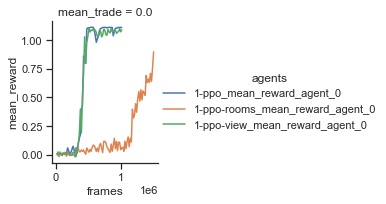

In [135]:
sns.relplot(x="frames", y="mean_reward", hue="agents",
            col="mean_trade", height=3,
            kind="line", estimator=None, data=lf)

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


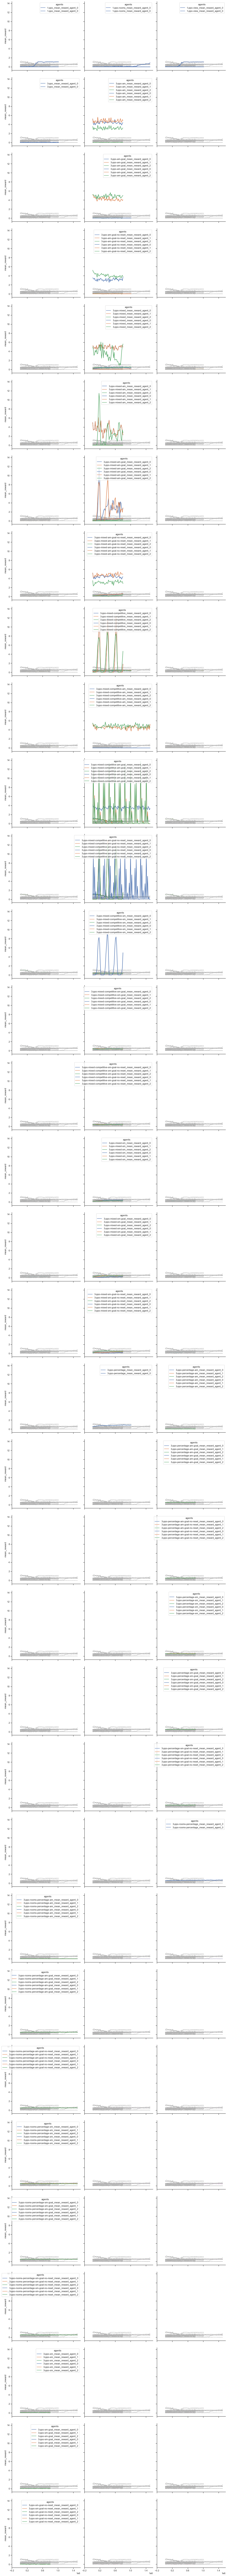

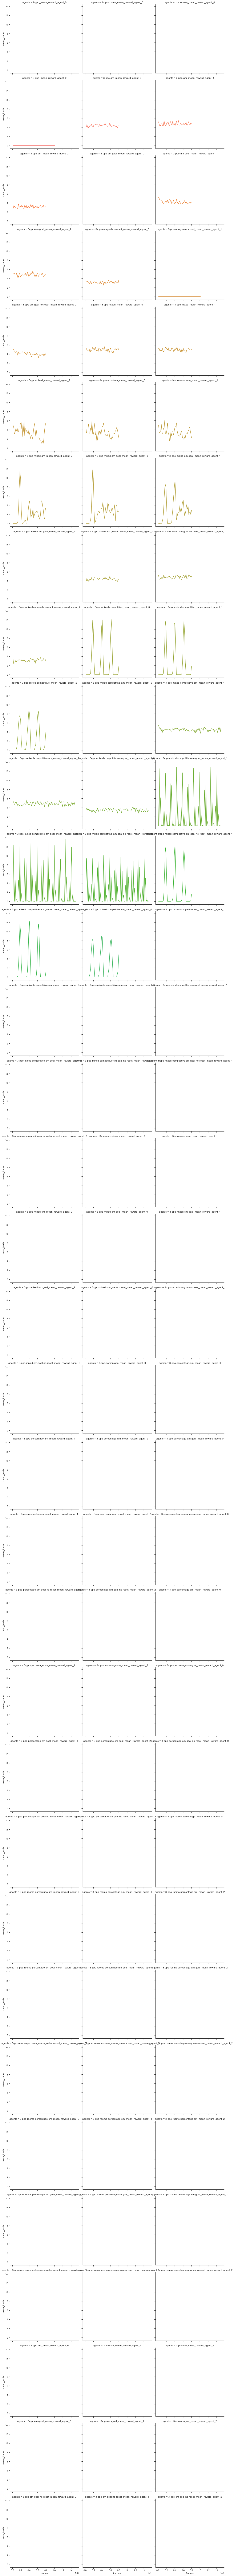

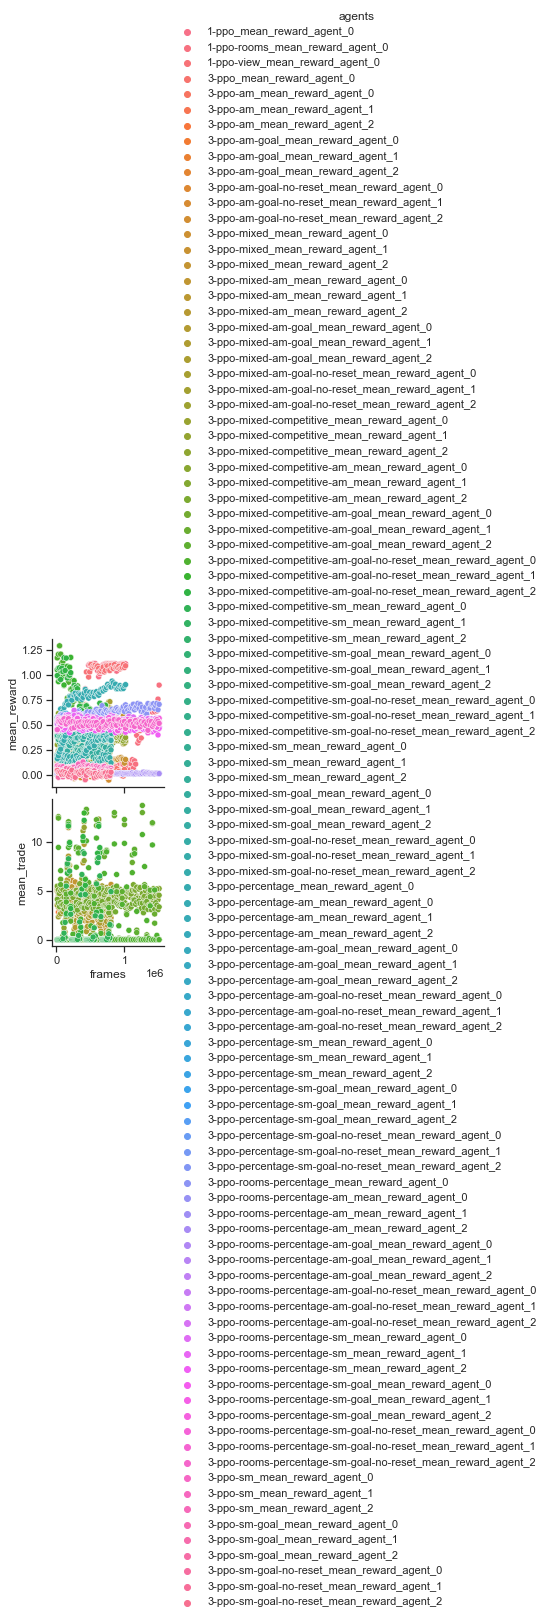

In [133]:
# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

g = sns.relplot(x="frames", y="mean_reward", col="agents", hue="agents", kind="line", data=lf, col_wrap=3, legend=False, ax=ax)

# Iterate over each subplot to customize further
for s, ax in g.axes_dict.items():
    title = " ".join(s.split("_mean")[0].split("-"))
    # s=current plot!! Add the title as an annotation within the plot
    # ax.text(.7, .85, title, transform=ax.transAxes, fontweight="bold")
    if "agent_0" in s: # check if more agent infos are available and plot them too!
        # in this case the agents have different values -> show all 
        # Plot every line greyed in the background
        setting = s.split("_agent")[0]
        lf_contains_agent = lf[lf['agents'].str.contains(setting)]
        lf_does_not_contain_agent = lf[~lf['agents'].str.contains(setting)]
        sns.lineplot(
            data=lf_contains_agent, x="frames", y="mean_reward", zorder=5,
            linewidth=2, ax=ax, hue="agents"
        )
        # Plot every line greyed in the background
        sns.lineplot(
            data=lf_does_not_contain_agent, x="frames", y="mean_reward", units="agents",
            estimator=None, color=".7", linewidth=1, ax=ax
        )
        #plot other setting values too
        sns.lineplot(data=lf_contains_agent, x="frames", y="mean_trade",zorder=5,
            linewidth=2, ax=ax, hue="agents")
    else:
        sns.lineplot(
            data=lf, x="frames", y="mean_reward", units="agents",
            estimator=None, color=".7", linewidth=1, ax=ax
        )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "mean_reward")

g = sns.relplot(x="frames", y="mean_trade", col="agents", hue="agents", kind="line", data=lf, col_wrap=3, legend=False, ax=ax)
g.tight_layout()
plt.tight_layout()
g = sns.pairplot(lf, x_vars=["frames"], y_vars=["mean_reward", "mean_trade"], hue="agents")

C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
C:\Users\Zarah\.virtualenvs\Coloring_with_CAP-xNNGJax5\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decoration

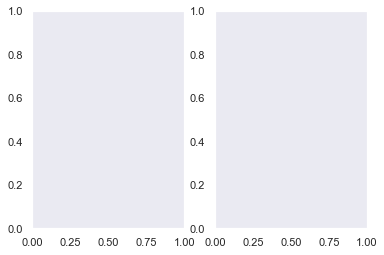

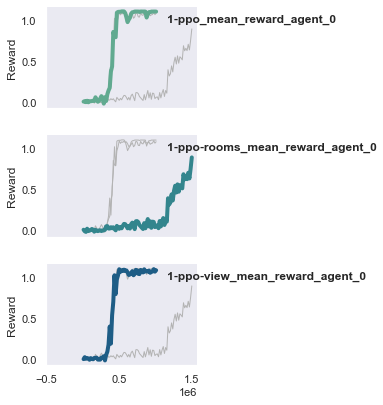

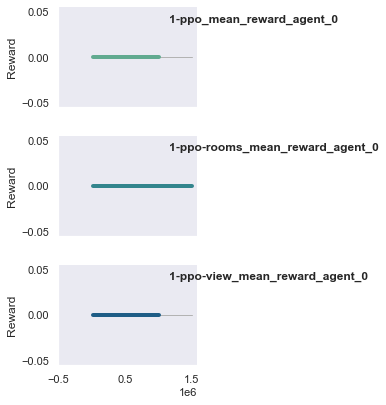

In [58]:
# g = sns.PairGrid(lf, y_vars=["mean_reward", "mean_trade"], x_vars=["frames"])
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()


# g = sns.relplot(data=lf, x='frames', y="mean_reward", hue='agents', row='agents', kind='line')

# sns.pairplot(lf, x_vars=["frames"], y_vars=["mean_reward", "mean_trade"], hue="agents")


sns.set_theme(style="dark")

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

# Plot each year's time series in its own facet
g = sns.relplot(
    data=lf,
    x="frames", y="mean_reward", col="agents", hue="agents",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=1, height=2, aspect=1.5, legend=False, ax=ax1
)

# Iterate over each subplot to customize further
for key, ax3 in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax3.text(.8, .85, key, transform=ax3.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=lf, x="frames", y="mean_reward", units="agents",
        estimator=None, color=".7", linewidth=1, ax=ax3,
    )

# Reduce the frequency of the x axis ticks
ax3.set_xticks(ax3.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Reward")
g.tight_layout()

# Plot each year's time series in its own facet
p = sns.relplot(
    data=lf,
    x="frames", y="mean_trade", col="agents", hue="agents",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=1, height=2, aspect=1.5, legend=False, ax=ax2
)

# Iterate over each subplot to customize further
for key, ax4 in p.axes_dict.items():

    # Add the title as an annotation within the plot
    ax4.text(.8, .85, key, transform=ax4.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=lf, x="frames", y="mean_trade", units="agents",
        estimator=None, color=".7", linewidth=1, ax=ax4,
    )

# Reduce the frequency of the x axis ticks
ax4.set_xticks(ax4.get_xticks()[::2])

# Tweak the supporting aspects of the plot
p.set_titles("")
p.set_axis_labels("", "Reward")
p.tight_layout()


fig.show()
